In [96]:
import os
import numpy as np
import pandas as pd
import xgboost as xgb
import lightgbm as lgb
import matplotlib.pyplot as plt
from bayes_opt import BayesianOptimization
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split

In [97]:
def preprocess(df):
    df["timestamp"] = pd.to_datetime(df['timestamp'], unit='s')
    df["year"] = df["timestamp"].dt.year
    df["month"] = df["timestamp"].dt.month
    df["day"] = df["timestamp"].dt.day
    df["hour"] = df["timestamp"].dt.hour
    df = df.drop(['timestamp', 'source'], axis=1)

    df = df[df['is_fishing'] != -1]
    df['is_fishing'] = df['is_fishing'] > 0.5
    df["course"] = df["course"].apply(lambda x: x - 360 if x >= 360 else x)
    return df

In [98]:
def generate_mmsi_samples(df, target, test_size=0.2, random_seed=42):
    np.random.seed(random_seed)
    mmsi_list = df['mmsi'].unique()
    test_num = int(len(mmsi_list) * test_size)
    mmsi_test = np.random.choice(mmsi_list, size=test_num, replace=False)
    df_test = df[df['mmsi'].isin(mmsi_test)].drop('mmsi', axis=1)
    df_train = df[~df['mmsi'].isin(mmsi_test)].drop('mmsi', axis=1)
    return df_train.drop(target, axis=1), df_test.drop(target, axis=1), df_train[target], df_test[target]

In [99]:
def lgb_train(train, target):
    data = lgb.Dataset(x_train, y_train)
    params = {
        'objective': 'binary',
        'boosting_type': 'gbdt',
        'max_depth': 5,
        'num_leaves': 200,
        'bagging_fraction': 0.9,
        'colsample_bytree': 0.9,
        'learning_rate': 0.03,
        'verbose': -1
    }
    model = lgb.train(params, data, num_boost_round=300)
    return model

In [100]:
def xgb_train(train, target):
    params = {
        'objective': 'binary:logistic',
        'colsample_bytree': 0.8,
        'colsample_bylevel': 0.8,
        'eval_metric': 'aucpr',
        'max_depth': 5,
        'eta': 0.05,
        'gamma': 0.1,
        'lambda': 2,
        'subsample': 0.8
    }
    data = xgb.DMatrix(train, target)
    model = xgb.train(params, data, num_boost_round=200)
    return model

In [124]:
df = pd.read_csv(os.path.join('..', 'data', 'trawlers.csv'))
df = preprocess(df)
x_train, x_test, y_train, y_test = generate_mmsi_samples(df, target='is_fishing', test_size=0.2, random_seed=40)
x_train.shape, x_test.shape

((156097, 10), (21297, 10))

## LightGBM

In [118]:
model = lgb_train(x_train, y_train)

In [119]:
y_pred = model.predict(x_test)

fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred, pos_label=1)
print("auc:", metrics.auc(fpr, tpr))

y_pred = y_pred.round(0)
print("f1 score:", metrics.f1_score(y_test, y_pred))
print("precision :", metrics.precision_score(y_test, y_pred))
print("recall :", metrics.recall_score(y_test, y_pred))
print("accuracy :", metrics.accuracy_score(y_test, y_pred))

auc: 0.9490949144751835
f1 score: 0.8772061882217776
precision : 0.853420697629601
recall : 0.9023555301980601
accuracy : 0.8975845889505684


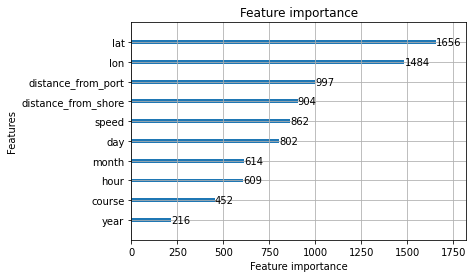

In [120]:
lgb.plot_importance(model)
plt.show()

## XGboost

In [10]:
model = xgb_train(x_train, y_train)

In [11]:
dtest = xgb.DMatrix(x_test, y_test)

y_pred = model.predict(dtest)

fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred, pos_label=1)
print("auc:", metrics.auc(fpr, tpr))

y_pred = y_pred.round(0)
print("f1 score:", metrics.f1_score(y_test, y_pred))
print("precision :", metrics.precision_score(y_test, y_pred))
print("recall :", metrics.recall_score(y_test, y_pred))
print("accuracy :", metrics.accuracy_score(y_test, y_pred))

auc: 0.9448080284706104
f1 score: 0.8787855044074437
precision : 0.8460697042848522
recall : 0.914133181188361


In [12]:
def xgb_plot_importance(model, save_as=None):
    feature_names = list(model.get_score().keys())
    feature_importance = list(model.get_score().values())
    d = pd.DataFrame(data={'feature': feature_names, 'importance': feature_importance})
    d = d.sort_values(by='importance', ascending=True)

    d.plot.barh('feature', 'importance')
    plt.title('Feature Importance')
    plt.xlabel('Weight')
    plt.ylabel('Features')
    plt.grid()
    if save_as:
        plt.savefig(save_as, bbox_inches='tight')
    plt.show()
    return

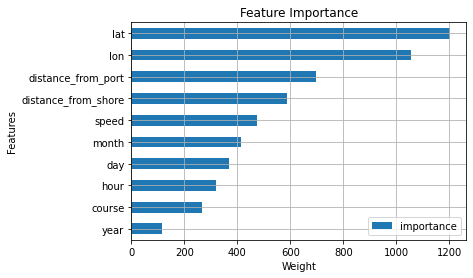

In [13]:
xgb_plot_importance(model)

## Testing Area

In [6]:
df = pd.read_csv('data/trawlers.csv')

In [7]:
df["timestamp"] = pd.to_datetime(df['timestamp'], unit='s')
df = df[df['is_fishing'] != -1]
df['is_fishing'] = df['is_fishing'] > 0.5

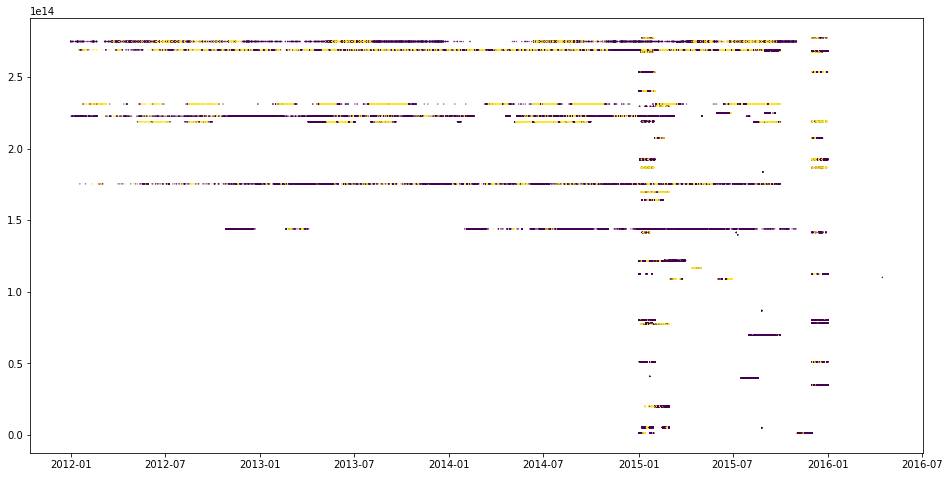

In [15]:
plt.figure(figsize=(16,8))
plt.scatter(x=df['timestamp'], y=df['mmsi'], c=df['is_fishing'],  s=0.1);

## Bayesian Optimization

In [114]:
def baeysian_opt_lgbm(train, target, init_iter=5, n_iters=20, random_state=42, seed=101):
    def lgb_f1_score(preds, dtrain):
        labels = dtrain.get_label()
        preds = preds.round(0)
        return 'f1', f1_score(labels, preds), True
    def hyp_lgbm(num_leaves, max_depth, bagging_fraction, colsample_bytree, learning_rate):
        params = {
            'objective': 'binary',
            'boosting_type': 'gbdt',
            'num_boosting_round': 300,
            'verbose': -1
        }
        params['num_leaves'] = int(round(num_leaves))
        params['max_depth'] = int(round(max_depth))
        params['bagging_fraction'] = bagging_fraction
        params['colsample_bytree'] = colsample_bytree
        params['learning_rate'] = learning_rate

        cv_results = lgb.cv(params, dtrain, nfold=5, seed=seed, feval=lgb_f1_score)
        return np.max(cv_results['f1-mean'])
        
    dtrain = lgb.Dataset(train, target)

    pds = {
        'num_leaves': (100, 300),
        'max_depth': (3, 7),
        'bagging_fraction': (0.7, 1),
        'colsample_bytree': (0.7, 1),
        'learning_rate': (0.01, 0.1)
    }
    optimizer = BayesianOptimization(hyp_lgbm, pds, random_state=random_state)
    optimizer.maximize(init_points=init_iter, n_iter=n_iters)
    return optimizer

def bo_lgb_train(opt, train, target):
    data = lgb.Dataset(train, target)
    params = {
        'objective': 'binary',
        'boosting_type': 'gbdt',
        'num_boosting_round': 300,
        'n_jobs': 2
    }
    params.update(opt.max['params'])
    params['num_leaves'] = int(round(params['num_leaves']))
    params['max_depth'] = int(round(params['max_depth']))
    model = lgb.train(params, data, num_boost_round=300)
    return model

In [115]:
opt = baeysian_opt_lgbm(x_train, y_train, n_iters=10)
model = bo_lgb_train(opt, x_train, y_train)

|   iter    |  target   | baggin... | colsam... | learni... | max_depth | num_le... |
-------------------------------------------------------------------------------------
[LightGBM] [Warning] Unknown parameter: num_boosting_round
|  1        |  0.9091   |  0.8124   |  0.9852   |  0.07588  |  5.395    |  131.2    |
|  2        |  0.9119   |  0.7468   |  0.7174   |  0.08796  |  5.404    |  241.6    |
|  3        |  0.9009   |  0.7062   |  0.991    |  0.08492  |  3.849    |  136.4    |
|  4        |  0.9044   |  0.755    |  0.7913   |  0.05723  |  4.728    |  158.2    |
|  5        |  0.8818   |  0.8836   |  0.7418   |  0.03629  |  4.465    |  191.2    |
|  6        |  0.9164   |  0.8199   |  0.7608   |  0.0621   |  5.671    |  250.0    |
|  7        |  0.9131   |  0.9719   |  0.7316   |  0.02325  |  6.701    |  254.1    |
|  8        |  0.9229   |  1.0      |  0.9244   |  0.0511   |  7.0      |  114.4    |
|  9        |  0.8661   |  0.7      |  0.7      |  0.02805  |  3.0      |  100.0 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

In [116]:
y_pred = model.predict(x_test)

fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred, pos_label=1)
print("auc:", metrics.auc(fpr, tpr))

y_pred = y_pred.round(0)
print("f1 score:", metrics.f1_score(y_test, y_pred))
print("precision :", metrics.precision_score(y_test, y_pred))
print("recall :", metrics.recall_score(y_test, y_pred))
print("accuracy :", metrics.accuracy_score(y_test, y_pred))

auc: 0.7978300678843042
f1 score: 0.5876037091264031
precision : 0.7852600684819827
recall : 0.46944146602982745
accuracy : 0.682584401558905


In [57]:
opt.max

{'target': 0.9362608408709809,
 'params': {'colsample_bytree': 0.7123368969813799,
  'feature_fraction': 0.7,
  'learning_rate': 0.09855957618690452,
  'max_depth': 5.280813736710855,
  'num_leaves': 237.7435729579604}}